Dependencies

In [ ]:
import gymnasium as gym
import ale_py
import imageio.v2 as imageio

Exploring environment

In [ ]:
env = gym.make("ALE/Pong-v5")



In [ ]:
obs, info = env.reset()

In [ ]:
env.spec

EnvSpec(id='ALE/Pong-v5', entry_point='ale_py.env:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, disable_env_checker=False, kwargs={'game': 'pong', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Pong', version=5, additional_wrappers=(), vector_entry_point='ale_py.vector_env:AtariVectorEnv')

In [ ]:
env.action_space

Discrete(6)

In [ ]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [ ]:
print(env.observation_space.low.shape)
print(env.observation_space.high.shape)
print(env.observation_space.low[0,0,0])
print(env.observation_space.high[0,0,0])

(210, 160, 3)
(210, 160, 3)
0
255


In [ ]:
print(env.action_space)
print(env.action_space.n)

Discrete(6)
6


In [ ]:
print(env.action_space.sample())
print(env.observation_space.sample().shape)

2
(210, 160, 3)


In [ ]:
obs,info = env.reset()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ...,

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]]], dtype=uint8)
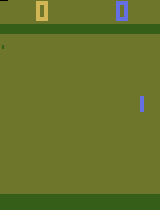

In [ ]:
obs

In [ ]:
info

{'lives': 0, 'episode_frame_number': 0, 'frame_number': 0}

Training DQN

In [ ]:
import torch.nn as nn
import torch.functional as F
import torch

class Q_Network(nn.Module):
  def __init__(self,output_size):
    super().__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(4,32,kernel_size = 8,stride = 4),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size = 4,stride = 2),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size = 3, stride = 1)
    )

    self.fc = nn.Sequential(
        nn.Linear(64*7*7,512),
        nn.ReLU(),
        nn.Linear(512,output_size)
    )

  def forward(self,x):
    x = x.float()/255.0
    x = self.cnn(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x


In [ ]:
import random
from collections import deque


class ReplayBuffer():
  def __init__(self,capacity,device):
    self.buffer = deque(maxlen=capacity)
    self.device = device

  def add(self,state,action,reward,next_state,done):
    self.buffer.append((state,action,reward,next_state,done))


  def sample(self,batch_size):
    batch = random.sample(self.buffer,batch_size)
    states,actions,rewards,next_states,dones = zip(*batch)
    states = torch.from_numpy(np.stack(states)).to(self.device)
    next_states = torch.from_numpy(np.stack(next_states)).to(self.device)


    return (
        states,
        torch.tensor(actions,dtype=torch.int32,device=self.device),
        torch.tensor(rewards,dtype=torch.float32,device=self.device),
        next_states,
        torch.tensor(dones,dtype=torch.float32,device=self.device)

    )

  def len(self):
    return len(self.buffer)



In [ ]:
import cv2
import numpy as np

def preprocess(obs):
    """
    obs: (210, 160, 3) uint8 RGB
    returns: (84, 84) uint8 grayscale
    """

    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    gray = gray[34:194, :]
    gray = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

    return gray.astype(np.uint8)


In [ ]:
import copy, random, os, imageio, torch, numpy as np
from collections import deque

SAVE_VIDEO_FREQ_1 = 25
SAVE_VIDEO_FREQ_2 = 60
VIDEO_DIR = "videos"
os.makedirs(VIDEO_DIR, exist_ok=True)

EPSILON_DECAY_START = 10000
TARGET_UPDATE_FREQ = 10_000


EPSILON_DECAY_STEPS = 1_500_000

MODEL_PATH = "models/qnet_latest.pt"

num_train_global_steps = 2_000_000
frame_stack_len = 4
max_steps = 10_000
batch_size = 32
gamma = 0.98

epsilon_start = 0.9
epsilon_min = 0.1
epsilon = epsilon_start

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_net = Q_Network(output_size=env.action_space.n).to(device)
target_q_net = copy.deepcopy(q_net).to(device)
target_q_net.eval()

optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-4)
loss_fn = torch.nn.SmoothL1Loss()

buffer = ReplayBuffer(capacity=200000, device=device)

global_steps = 0
episode_num = 1

while global_steps < num_train_global_steps:

    total_reward = 0
    obs, info = env.reset()
    obs_proc = preprocess(obs)

    frame_stack = deque([obs_proc] * frame_stack_len, maxlen=frame_stack_len)
    state = np.stack(frame_stack, axis=0)

    for step in range(max_steps):
        global_steps += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_vals = q_net(torch.tensor(state, device=device).unsqueeze(0))
                action = torch.argmax(q_vals).item()

        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_proc = preprocess(obs)
        frame_stack.append(obs_proc)
        next_state = np.stack(frame_stack, axis=0)

        buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if buffer.len() >= batch_size and global_steps > 10_000:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            with torch.no_grad():
                next_q = target_q_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q * (1 - dones)

            q = q_net(states)
            q = q.gather(1, actions.unsqueeze(1)).squeeze(1)

            loss = loss_fn(q, targets)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
            optimizer.step()

        if global_steps % TARGET_UPDATE_FREQ == 0:
            target_q_net.load_state_dict(q_net.state_dict())

        if done:
            break

    if global_steps > EPSILON_DECAY_START:
        decay_ratio = min(
            1.0,
            (global_steps - EPSILON_DECAY_START) / EPSILON_DECAY_STEPS
        )
        epsilon = max(
            epsilon_min,
            epsilon_start - decay_ratio * (epsilon_start - epsilon_min)
        )

    if episode_num % SAVE_VIDEO_FREQ_1==0:
      q_net.eval()
      frames = []
      eval_reward = 0

      obs, info = env.reset()
      obs_proc = preprocess(obs)

      eval_stack = deque([obs_proc] * frame_stack_len, maxlen=frame_stack_len)
      eval_state = np.stack(eval_stack, axis=0)

      for _ in range(max_steps):
          frames.append(obs)

          with torch.no_grad():
              q_vals = q_net(
                  torch.tensor(eval_state, device=device).unsqueeze(0)
              )
              action = torch.argmax(q_vals).item()

          obs, r, term, trunc, _ = env.step(action)
          eval_reward += r

          obs_proc = preprocess(obs)
          eval_stack.append(obs_proc)
          eval_state = np.stack(eval_stack, axis=0)

          if term or trunc:
              break
      video_path = f"{VIDEO_DIR}/episode_{episode_num}_steps_{global_steps}.mp4"
      imageio.mimsave(video_path, frames, fps=30)
      print("VIDEO SAVED:", video_path, "reward:", eval_reward)

      torch.save({"episode": episode_num,"global_steps": global_steps,"model_state_dict": q_net.state_dict(),
                  "optimizer_state_dict": optimizer.state_dict(),"epsilon": epsilon,}, MODEL_PATH)

      q_net.train()


    print(f"Episode : {episode_num}, Reward : {total_reward}, Epsilon : {epsilon}, Buffer length : {buffer.len()}, Steps : {global_steps}")
    episode_num += 1


Episode : 1, Reward : -19.0, Epsilon : 0.9, Buffer length : 1023, Steps : 1023
Episode : 2, Reward : -21.0, Epsilon : 0.9, Buffer length : 1937, Steps : 1937
Episode : 3, Reward : -21.0, Epsilon : 0.9, Buffer length : 2761, Steps : 2761
Episode : 4, Reward : -18.0, Epsilon : 0.9, Buffer length : 3967, Steps : 3967
Episode : 5, Reward : -21.0, Epsilon : 0.9, Buffer length : 4808, Steps : 4808
Episode : 6, Reward : -21.0, Epsilon : 0.9, Buffer length : 5748, Steps : 5748
Episode : 7, Reward : -20.0, Epsilon : 0.9, Buffer length : 6636, Steps : 6636
Episode : 8, Reward : -21.0, Epsilon : 0.9, Buffer length : 7578, Steps : 7578
Episode : 9, Reward : -19.0, Epsilon : 0.9, Buffer length : 8665, Steps : 8665
Episode : 10, Reward : -21.0, Epsilon : 0.9, Buffer length : 9538, Steps : 9538
Episode : 11, Reward : -20.0, Epsilon : 0.8997397333333333, Buffer length : 10488, Steps : 10488
Episode : 12, Reward : -21.0, Epsilon : 0.8992042666666666, Buffer length : 11492, Steps : 11492
Episode : 13, R

VIDEO SAVED: videos/episode_25_steps_23364.mp4 reward: -21.0
Episode : 25, Reward : -20.0, Epsilon : 0.8928725333333334, Buffer length : 23364, Steps : 23364
Episode : 26, Reward : -20.0, Epsilon : 0.8923930666666667, Buffer length : 24263, Steps : 24263
Episode : 27, Reward : -17.0, Epsilon : 0.891664, Buffer length : 25630, Steps : 25630
Episode : 28, Reward : -18.0, Epsilon : 0.8910805333333334, Buffer length : 26724, Steps : 26724
Episode : 29, Reward : -16.0, Epsilon : 0.8904032000000001, Buffer length : 27994, Steps : 27994
Episode : 30, Reward : -20.0, Epsilon : 0.8897797333333334, Buffer length : 29163, Steps : 29163
Episode : 31, Reward : -21.0, Epsilon : 0.8892613333333333, Buffer length : 30135, Steps : 30135
Episode : 32, Reward : -20.0, Epsilon : 0.8885952, Buffer length : 31384, Steps : 31384
Episode : 33, Reward : -20.0, Epsilon : 0.8880042666666667, Buffer length : 32492, Steps : 32492
Episode : 34, Reward : -21.0, Epsilon : 0.8875637333333334, Buffer length : 33318, St

VIDEO SAVED: videos/episode_50_steps_48376.mp4 reward: -21.0
Episode : 50, Reward : -20.0, Epsilon : 0.8795328, Buffer length : 48376, Steps : 48376
Episode : 51, Reward : -21.0, Epsilon : 0.8790922666666667, Buffer length : 49202, Steps : 49202
Episode : 52, Reward : -21.0, Epsilon : 0.8785573333333334, Buffer length : 50205, Steps : 50205
Episode : 53, Reward : -21.0, Epsilon : 0.8781349333333334, Buffer length : 50997, Steps : 50997
Episode : 54, Reward : -20.0, Epsilon : 0.8776448, Buffer length : 51916, Steps : 51916
Episode : 55, Reward : -19.0, Epsilon : 0.8771130666666667, Buffer length : 52913, Steps : 52913
Episode : 56, Reward : -21.0, Epsilon : 0.8766906666666667, Buffer length : 53705, Steps : 53705
Episode : 57, Reward : -21.0, Epsilon : 0.8762357333333334, Buffer length : 54558, Steps : 54558
Episode : 58, Reward : -21.0, Epsilon : 0.8757664000000001, Buffer length : 55438, Steps : 55438
Episode : 59, Reward : -20.0, Epsilon : 0.8751776, Buffer length : 56542, Steps : 56

VIDEO SAVED: videos/episode_75_steps_71701.mp4 reward: -20.0
Episode : 75, Reward : -19.0, Epsilon : 0.8670928, Buffer length : 71701, Steps : 71701
Episode : 76, Reward : -21.0, Epsilon : 0.8665786666666667, Buffer length : 72665, Steps : 72665
Episode : 77, Reward : -21.0, Epsilon : 0.8661242666666666, Buffer length : 73517, Steps : 73517
Episode : 78, Reward : -20.0, Epsilon : 0.8655637333333334, Buffer length : 74568, Steps : 74568
Episode : 79, Reward : -21.0, Epsilon : 0.8650789333333333, Buffer length : 75477, Steps : 75477
Episode : 80, Reward : -18.0, Epsilon : 0.8643701333333333, Buffer length : 76806, Steps : 76806
Episode : 81, Reward : -21.0, Epsilon : 0.8638677333333333, Buffer length : 77748, Steps : 77748
Episode : 82, Reward : -21.0, Epsilon : 0.8634128, Buffer length : 78601, Steps : 78601
Episode : 83, Reward : -19.0, Epsilon : 0.8629210666666667, Buffer length : 79523, Steps : 79523
Episode : 84, Reward : -21.0, Epsilon : 0.8624346666666667, Buffer length : 80435, S

VIDEO SAVED: videos/episode_100_steps_96515.mp4 reward: -21.0
Episode : 100, Reward : -18.0, Epsilon : 0.8538586666666667, Buffer length : 96515, Steps : 96515
Episode : 101, Reward : -20.0, Epsilon : 0.8533456, Buffer length : 97477, Steps : 97477
Episode : 102, Reward : -20.0, Epsilon : 0.8527925333333334, Buffer length : 98514, Steps : 98514
Episode : 103, Reward : -15.0, Epsilon : 0.8520245333333334, Buffer length : 99954, Steps : 99954
Episode : 104, Reward : -20.0, Epsilon : 0.8514624000000001, Buffer length : 101008, Steps : 101008
Episode : 105, Reward : -20.0, Epsilon : 0.8508362666666667, Buffer length : 102182, Steps : 102182
Episode : 106, Reward : -18.0, Epsilon : 0.850232, Buffer length : 103315, Steps : 103315
Episode : 107, Reward : -19.0, Epsilon : 0.8496922666666666, Buffer length : 104327, Steps : 104327
Episode : 108, Reward : -20.0, Epsilon : 0.8492432, Buffer length : 105169, Steps : 105169
Episode : 109, Reward : -20.0, Epsilon : 0.8487520000000001, Buffer length

VIDEO SAVED: videos/episode_125_steps_122414.mp4 reward: -21.0
Episode : 125, Reward : -21.0, Epsilon : 0.8400458666666667, Buffer length : 122414, Steps : 122414
Episode : 126, Reward : -20.0, Epsilon : 0.8395002666666667, Buffer length : 123437, Steps : 123437
Episode : 127, Reward : -21.0, Epsilon : 0.8390778666666667, Buffer length : 124229, Steps : 124229
Episode : 128, Reward : -21.0, Epsilon : 0.8385733333333334, Buffer length : 125175, Steps : 125175
Episode : 129, Reward : -19.0, Epsilon : 0.8379989333333333, Buffer length : 126252, Steps : 126252
Episode : 130, Reward : -20.0, Epsilon : 0.8373973333333333, Buffer length : 127380, Steps : 127380
Episode : 131, Reward : -21.0, Epsilon : 0.8368453333333333, Buffer length : 128415, Steps : 128415
Episode : 132, Reward : -21.0, Epsilon : 0.8363269333333334, Buffer length : 129387, Steps : 129387
Episode : 133, Reward : -19.0, Epsilon : 0.8357770666666667, Buffer length : 130418, Steps : 130418
Episode : 134, Reward : -21.0, Epsilo

VIDEO SAVED: videos/episode_150_steps_148955.mp4 reward: -15.0
Episode : 150, Reward : -21.0, Epsilon : 0.8258906666666667, Buffer length : 148955, Steps : 148955
Episode : 151, Reward : -20.0, Epsilon : 0.8253818666666667, Buffer length : 149909, Steps : 149909
Episode : 152, Reward : -18.0, Epsilon : 0.8247525333333333, Buffer length : 151089, Steps : 151089
Episode : 153, Reward : -20.0, Epsilon : 0.8241077333333333, Buffer length : 152298, Steps : 152298
Episode : 154, Reward : -20.0, Epsilon : 0.8235157333333334, Buffer length : 153408, Steps : 153408
Episode : 155, Reward : -21.0, Epsilon : 0.8230661333333333, Buffer length : 154251, Steps : 154251
Episode : 156, Reward : -19.0, Epsilon : 0.8224352, Buffer length : 155434, Steps : 155434
Episode : 157, Reward : -19.0, Epsilon : 0.8218053333333334, Buffer length : 156615, Steps : 156615
Episode : 158, Reward : -19.0, Epsilon : 0.8212522666666666, Buffer length : 157652, Steps : 157652
Episode : 159, Reward : -19.0, Epsilon : 0.820

VIDEO SAVED: videos/episode_175_steps_175784.mp4 reward: -16.0
Episode : 175, Reward : -17.0, Epsilon : 0.8115818666666667, Buffer length : 175784, Steps : 175784
Episode : 176, Reward : -17.0, Epsilon : 0.8108794666666667, Buffer length : 177101, Steps : 177101
Episode : 177, Reward : -21.0, Epsilon : 0.8103301333333334, Buffer length : 178131, Steps : 178131
Episode : 178, Reward : -19.0, Epsilon : 0.8097296, Buffer length : 179257, Steps : 179257
Episode : 179, Reward : -20.0, Epsilon : 0.8091237333333333, Buffer length : 180393, Steps : 180393
Episode : 180, Reward : -20.0, Epsilon : 0.8084869333333333, Buffer length : 181587, Steps : 181587
Episode : 181, Reward : -18.0, Epsilon : 0.8079024, Buffer length : 182683, Steps : 182683
Episode : 182, Reward : -21.0, Epsilon : 0.80732, Buffer length : 183775, Steps : 183775
Episode : 183, Reward : -21.0, Epsilon : 0.8068256, Buffer length : 184702, Steps : 184702
Episode : 184, Reward : -21.0, Epsilon : 0.8062922666666666, Buffer length 

VIDEO SAVED: videos/episode_200_steps_204591.mp4 reward: -14.0
Episode : 200, Reward : -21.0, Epsilon : 0.7962181333333334, Buffer length : 200000, Steps : 204591
Episode : 201, Reward : -20.0, Epsilon : 0.7956149333333333, Buffer length : 200000, Steps : 205722
Episode : 202, Reward : -20.0, Epsilon : 0.7951402666666667, Buffer length : 200000, Steps : 206612
Episode : 203, Reward : -19.0, Epsilon : 0.7945424, Buffer length : 200000, Steps : 207733
Episode : 204, Reward : -19.0, Epsilon : 0.7940277333333333, Buffer length : 200000, Steps : 208698
Episode : 205, Reward : -18.0, Epsilon : 0.7933765333333334, Buffer length : 200000, Steps : 209919
Episode : 206, Reward : -20.0, Epsilon : 0.7928426666666667, Buffer length : 200000, Steps : 210920
Episode : 207, Reward : -18.0, Epsilon : 0.792064, Buffer length : 200000, Steps : 212380
Episode : 208, Reward : -21.0, Epsilon : 0.7915456000000001, Buffer length : 200000, Steps : 213352
Episode : 209, Reward : -20.0, Epsilon : 0.7909989333333

VIDEO SAVED: videos/episode_225_steps_234222.mp4 reward: -15.0
Episode : 225, Reward : -17.0, Epsilon : 0.7804149333333333, Buffer length : 200000, Steps : 234222
Episode : 226, Reward : -20.0, Epsilon : 0.7797738666666667, Buffer length : 200000, Steps : 235424
Episode : 227, Reward : -21.0, Epsilon : 0.7793024, Buffer length : 200000, Steps : 236308
Episode : 228, Reward : -17.0, Epsilon : 0.778512, Buffer length : 200000, Steps : 237790
Episode : 229, Reward : -21.0, Epsilon : 0.7780026666666666, Buffer length : 200000, Steps : 238745
Episode : 230, Reward : -20.0, Epsilon : 0.7774234666666666, Buffer length : 200000, Steps : 239831
Episode : 231, Reward : -20.0, Epsilon : 0.7768976000000001, Buffer length : 200000, Steps : 240817
Episode : 232, Reward : -20.0, Epsilon : 0.7763024000000001, Buffer length : 200000, Steps : 241933
Episode : 233, Reward : -19.0, Epsilon : 0.7756917333333333, Buffer length : 200000, Steps : 243078
Episode : 234, Reward : -18.0, Epsilon : 0.7750202666666

VIDEO SAVED: videos/episode_250_steps_262815.mp4 reward: -15.0
Episode : 250, Reward : -19.0, Epsilon : 0.7651653333333334, Buffer length : 200000, Steps : 262815
Episode : 251, Reward : -21.0, Epsilon : 0.7645365333333334, Buffer length : 200000, Steps : 263994
Episode : 252, Reward : -20.0, Epsilon : 0.7639685333333334, Buffer length : 200000, Steps : 265059
Episode : 253, Reward : -21.0, Epsilon : 0.7634650666666667, Buffer length : 200000, Steps : 266003
Episode : 254, Reward : -19.0, Epsilon : 0.7628314666666667, Buffer length : 200000, Steps : 267191
Episode : 255, Reward : -19.0, Epsilon : 0.762144, Buffer length : 200000, Steps : 268480
Episode : 256, Reward : -18.0, Epsilon : 0.7613445333333333, Buffer length : 200000, Steps : 269979
Episode : 257, Reward : -19.0, Epsilon : 0.7606384, Buffer length : 200000, Steps : 271303
Episode : 258, Reward : -21.0, Epsilon : 0.7601685333333333, Buffer length : 200000, Steps : 272184
Episode : 259, Reward : -19.0, Epsilon : 0.7595242666666

VIDEO SAVED: videos/episode_275_steps_292427.mp4 reward: -10.0
Episode : 275, Reward : -20.0, Epsilon : 0.7493722666666667, Buffer length : 200000, Steps : 292427
Episode : 276, Reward : -20.0, Epsilon : 0.7488192, Buffer length : 200000, Steps : 293464
Episode : 277, Reward : -20.0, Epsilon : 0.7482933333333334, Buffer length : 200000, Steps : 294450
Episode : 278, Reward : -17.0, Epsilon : 0.7476586666666667, Buffer length : 200000, Steps : 295640
Episode : 279, Reward : -20.0, Epsilon : 0.7470421333333334, Buffer length : 200000, Steps : 296796
Episode : 280, Reward : -20.0, Epsilon : 0.7464042666666667, Buffer length : 200000, Steps : 297992
Episode : 281, Reward : -20.0, Epsilon : 0.7458277333333334, Buffer length : 200000, Steps : 299073
Episode : 282, Reward : -19.0, Epsilon : 0.7452112, Buffer length : 200000, Steps : 300229
Episode : 283, Reward : -19.0, Epsilon : 0.7443946666666666, Buffer length : 200000, Steps : 301760
Episode : 284, Reward : -19.0, Epsilon : 0.743855466666

VIDEO SAVED: videos/episode_300_steps_322553.mp4 reward: -16.0
Episode : 300, Reward : -21.0, Epsilon : 0.7333050666666667, Buffer length : 200000, Steps : 322553
Episode : 301, Reward : -19.0, Epsilon : 0.7326272, Buffer length : 200000, Steps : 323824
Episode : 302, Reward : -20.0, Epsilon : 0.7319882666666667, Buffer length : 200000, Steps : 325022
Episode : 303, Reward : -19.0, Epsilon : 0.7313285333333334, Buffer length : 200000, Steps : 326259
Episode : 304, Reward : -20.0, Epsilon : 0.7306314666666667, Buffer length : 200000, Steps : 327566
Episode : 305, Reward : -17.0, Epsilon : 0.7298986666666667, Buffer length : 200000, Steps : 328940
Episode : 306, Reward : -19.0, Epsilon : 0.7291189333333333, Buffer length : 200000, Steps : 330402
Episode : 307, Reward : -21.0, Epsilon : 0.7286117333333333, Buffer length : 200000, Steps : 331353
Episode : 308, Reward : -19.0, Epsilon : 0.7279210666666667, Buffer length : 200000, Steps : 332648
Episode : 309, Reward : -20.0, Epsilon : 0.727

VIDEO SAVED: videos/episode_325_steps_352785.mp4 reward: -11.0
Episode : 325, Reward : -20.0, Epsilon : 0.7171813333333333, Buffer length : 200000, Steps : 352785
Episode : 326, Reward : -18.0, Epsilon : 0.7164501333333333, Buffer length : 200000, Steps : 354156
Episode : 327, Reward : -18.0, Epsilon : 0.7158026666666667, Buffer length : 200000, Steps : 355370
Episode : 328, Reward : -17.0, Epsilon : 0.7150997333333333, Buffer length : 200000, Steps : 356688
Episode : 329, Reward : -21.0, Epsilon : 0.7145168, Buffer length : 200000, Steps : 357781
Episode : 330, Reward : -18.0, Epsilon : 0.7138058666666667, Buffer length : 200000, Steps : 359114
Episode : 331, Reward : -19.0, Epsilon : 0.7132437333333334, Buffer length : 200000, Steps : 360168
Episode : 332, Reward : -19.0, Epsilon : 0.7125866666666667, Buffer length : 200000, Steps : 361400
Episode : 333, Reward : -17.0, Epsilon : 0.7118666666666666, Buffer length : 200000, Steps : 362750
Episode : 334, Reward : -20.0, Epsilon : 0.711

VIDEO SAVED: videos/episode_350_steps_383183.mp4 reward: -9.0
Episode : 350, Reward : -18.0, Epsilon : 0.7009690666666667, Buffer length : 200000, Steps : 383183
Episode : 351, Reward : -19.0, Epsilon : 0.7003802666666666, Buffer length : 200000, Steps : 384287
Episode : 352, Reward : -21.0, Epsilon : 0.6997984, Buffer length : 200000, Steps : 385378
Episode : 353, Reward : -20.0, Epsilon : 0.6992229333333333, Buffer length : 200000, Steps : 386457
Episode : 354, Reward : -21.0, Epsilon : 0.6986608, Buffer length : 200000, Steps : 387511
Episode : 355, Reward : -19.0, Epsilon : 0.6980314666666667, Buffer length : 200000, Steps : 388691
Episode : 356, Reward : -20.0, Epsilon : 0.6974042666666667, Buffer length : 200000, Steps : 389867
Episode : 357, Reward : -20.0, Epsilon : 0.6966538666666666, Buffer length : 200000, Steps : 391274
Episode : 358, Reward : -20.0, Epsilon : 0.6961093333333334, Buffer length : 200000, Steps : 392295
Episode : 359, Reward : -18.0, Epsilon : 0.6954112, Buff

VIDEO SAVED: videos/episode_375_steps_413477.mp4 reward: -9.0
Episode : 375, Reward : -20.0, Epsilon : 0.6848122666666667, Buffer length : 200000, Steps : 413477
Episode : 376, Reward : -19.0, Epsilon : 0.6840064, Buffer length : 200000, Steps : 414988
Episode : 377, Reward : -18.0, Epsilon : 0.6833253333333333, Buffer length : 200000, Steps : 416265
Episode : 378, Reward : -20.0, Epsilon : 0.6826789333333333, Buffer length : 200000, Steps : 417477
Episode : 379, Reward : -17.0, Epsilon : 0.6819338666666667, Buffer length : 200000, Steps : 418874
Episode : 380, Reward : -18.0, Epsilon : 0.6812469333333333, Buffer length : 200000, Steps : 420162
Episode : 381, Reward : -21.0, Epsilon : 0.6806912, Buffer length : 200000, Steps : 421204
Episode : 382, Reward : -21.0, Epsilon : 0.680112, Buffer length : 200000, Steps : 422290
Episode : 383, Reward : -21.0, Epsilon : 0.6796314666666666, Buffer length : 200000, Steps : 423191
Episode : 384, Reward : -18.0, Epsilon : 0.678984, Buffer length :

VIDEO SAVED: videos/episode_400_steps_445010.mp4 reward: -10.0
Episode : 400, Reward : -20.0, Epsilon : 0.6679946666666666, Buffer length : 200000, Steps : 445010
Episode : 401, Reward : -20.0, Epsilon : 0.6674533333333333, Buffer length : 200000, Steps : 446025
Episode : 402, Reward : -19.0, Epsilon : 0.6666581333333333, Buffer length : 200000, Steps : 447516
Episode : 403, Reward : -20.0, Epsilon : 0.6661349333333333, Buffer length : 200000, Steps : 448497
Episode : 404, Reward : -19.0, Epsilon : 0.6654922666666667, Buffer length : 200000, Steps : 449702
Episode : 405, Reward : -18.0, Epsilon : 0.6647925333333333, Buffer length : 200000, Steps : 451014
Episode : 406, Reward : -21.0, Epsilon : 0.6641264, Buffer length : 200000, Steps : 452263
Episode : 407, Reward : -19.0, Epsilon : 0.6634096, Buffer length : 200000, Steps : 453607
Episode : 408, Reward : -18.0, Epsilon : 0.6627674666666666, Buffer length : 200000, Steps : 454811
Episode : 409, Reward : -18.0, Epsilon : 0.662162666666

VIDEO SAVED: videos/episode_425_steps_476128.mp4 reward: -17.0
Episode : 425, Reward : -20.0, Epsilon : 0.6513984, Buffer length : 200000, Steps : 476128
Episode : 426, Reward : -17.0, Epsilon : 0.6504709333333334, Buffer length : 200000, Steps : 477867
Episode : 427, Reward : -21.0, Epsilon : 0.6498698666666667, Buffer length : 200000, Steps : 478994
Episode : 428, Reward : -21.0, Epsilon : 0.6491749333333334, Buffer length : 200000, Steps : 480297
Episode : 429, Reward : -20.0, Epsilon : 0.648528, Buffer length : 200000, Steps : 481510
Episode : 430, Reward : -20.0, Epsilon : 0.6479007999999999, Buffer length : 200000, Steps : 482686
Episode : 431, Reward : -20.0, Epsilon : 0.6473322666666668, Buffer length : 200000, Steps : 483752
Episode : 432, Reward : -17.0, Epsilon : 0.6465536000000001, Buffer length : 200000, Steps : 485212
Episode : 433, Reward : -17.0, Epsilon : 0.6457754666666666, Buffer length : 200000, Steps : 486671
Episode : 434, Reward : -18.0, Epsilon : 0.6450016000000

VIDEO SAVED: videos/episode_450_steps_509368.mp4 reward: -7.0
Episode : 450, Reward : -14.0, Epsilon : 0.6336704, Buffer length : 200000, Steps : 509368
Episode : 451, Reward : -17.0, Epsilon : 0.6329210666666667, Buffer length : 200000, Steps : 510773
Episode : 452, Reward : -17.0, Epsilon : 0.6322106666666667, Buffer length : 200000, Steps : 512105
Episode : 453, Reward : -17.0, Epsilon : 0.6314437333333334, Buffer length : 200000, Steps : 513543
Episode : 454, Reward : -16.0, Epsilon : 0.6306506666666667, Buffer length : 200000, Steps : 515030
Episode : 455, Reward : -21.0, Epsilon : 0.6299008, Buffer length : 200000, Steps : 516436
Episode : 456, Reward : -17.0, Epsilon : 0.6291450666666667, Buffer length : 200000, Steps : 517853
Episode : 457, Reward : -20.0, Epsilon : 0.6283370666666668, Buffer length : 200000, Steps : 519368
Episode : 458, Reward : -19.0, Epsilon : 0.6275285333333334, Buffer length : 200000, Steps : 520884
Episode : 459, Reward : -19.0, Epsilon : 0.6267925333333

VIDEO SAVED: videos/episode_475_steps_543941.mp4 reward: -9.0
Episode : 475, Reward : -19.0, Epsilon : 0.6152314666666667, Buffer length : 200000, Steps : 543941
Episode : 476, Reward : -16.0, Epsilon : 0.6143568, Buffer length : 200000, Steps : 545581
Episode : 477, Reward : -17.0, Epsilon : 0.6135248, Buffer length : 200000, Steps : 547141
Episode : 478, Reward : -19.0, Epsilon : 0.6128458666666667, Buffer length : 200000, Steps : 548414
Episode : 479, Reward : -20.0, Epsilon : 0.6121786666666666, Buffer length : 200000, Steps : 549665
Episode : 480, Reward : -17.0, Epsilon : 0.6114170666666667, Buffer length : 200000, Steps : 551093
Episode : 481, Reward : -18.0, Epsilon : 0.6105914666666667, Buffer length : 200000, Steps : 552641
Episode : 482, Reward : -19.0, Epsilon : 0.6099829333333333, Buffer length : 200000, Steps : 553782
Episode : 483, Reward : -20.0, Epsilon : 0.6091253333333333, Buffer length : 200000, Steps : 555390
Episode : 484, Reward : -16.0, Epsilon : 0.6079920000000

VIDEO SAVED: videos/episode_500_steps_579891.mp4 reward: -16.0
Episode : 500, Reward : -20.0, Epsilon : 0.5960581333333334, Buffer length : 200000, Steps : 579891
Episode : 501, Reward : -17.0, Epsilon : 0.5952730666666667, Buffer length : 200000, Steps : 581363
Episode : 502, Reward : -17.0, Epsilon : 0.5945029333333334, Buffer length : 200000, Steps : 582807
Episode : 503, Reward : -13.0, Epsilon : 0.5935808, Buffer length : 200000, Steps : 584536
Episode : 504, Reward : -17.0, Epsilon : 0.5927989333333333, Buffer length : 200000, Steps : 586002
Episode : 505, Reward : -19.0, Epsilon : 0.5920485333333333, Buffer length : 200000, Steps : 587409
Episode : 506, Reward : -19.0, Epsilon : 0.5912325333333334, Buffer length : 200000, Steps : 588939
Episode : 507, Reward : -19.0, Epsilon : 0.5903925333333333, Buffer length : 200000, Steps : 590514
Episode : 508, Reward : -19.0, Epsilon : 0.5896496, Buffer length : 200000, Steps : 591907
Episode : 509, Reward : -20.0, Epsilon : 0.5890016, Buf

VIDEO SAVED: videos/episode_525_steps_618092.mp4 reward: 4.0
Episode : 525, Reward : -16.0, Epsilon : 0.5756842666666666, Buffer length : 200000, Steps : 618092
Episode : 526, Reward : -19.0, Epsilon : 0.5749429333333334, Buffer length : 200000, Steps : 619482
Episode : 527, Reward : -18.0, Epsilon : 0.5742250666666666, Buffer length : 200000, Steps : 620828
Episode : 528, Reward : -20.0, Epsilon : 0.5736309333333334, Buffer length : 200000, Steps : 621942
Episode : 529, Reward : -20.0, Epsilon : 0.5729237333333334, Buffer length : 200000, Steps : 623268
Episode : 530, Reward : -17.0, Epsilon : 0.5721365333333334, Buffer length : 200000, Steps : 624744
Episode : 531, Reward : -16.0, Epsilon : 0.5710672, Buffer length : 200000, Steps : 626749
Episode : 532, Reward : -19.0, Epsilon : 0.5703808, Buffer length : 200000, Steps : 628036
Episode : 533, Reward : -17.0, Epsilon : 0.5694464, Buffer length : 200000, Steps : 629788
Episode : 534, Reward : -16.0, Epsilon : 0.5684048, Buffer length 

VIDEO SAVED: videos/episode_550_steps_655189.mp4 reward: -8.0
Episode : 550, Reward : -19.0, Epsilon : 0.5558992, Buffer length : 200000, Steps : 655189
Episode : 551, Reward : -18.0, Epsilon : 0.5550266666666667, Buffer length : 200000, Steps : 656825
Episode : 552, Reward : -17.0, Epsilon : 0.5540138666666666, Buffer length : 200000, Steps : 658724
Episode : 553, Reward : -18.0, Epsilon : 0.5531178666666666, Buffer length : 200000, Steps : 660404
Episode : 554, Reward : -21.0, Epsilon : 0.5524805333333334, Buffer length : 200000, Steps : 661599
Episode : 555, Reward : -20.0, Epsilon : 0.5518202666666667, Buffer length : 200000, Steps : 662837
Episode : 556, Reward : -17.0, Epsilon : 0.5510933333333333, Buffer length : 200000, Steps : 664200
Episode : 557, Reward : -19.0, Epsilon : 0.550544, Buffer length : 200000, Steps : 665230
Episode : 558, Reward : -15.0, Epsilon : 0.5494736, Buffer length : 200000, Steps : 667237
Episode : 559, Reward : -19.0, Epsilon : 0.5486752, Buffer length 

VIDEO SAVED: videos/episode_575_steps_692487.mp4 reward: -9.0
Episode : 575, Reward : -20.0, Epsilon : 0.5360069333333333, Buffer length : 200000, Steps : 692487
Episode : 576, Reward : -19.0, Epsilon : 0.535312, Buffer length : 200000, Steps : 693790
Episode : 577, Reward : -19.0, Epsilon : 0.5346128, Buffer length : 200000, Steps : 695101
Episode : 578, Reward : -18.0, Epsilon : 0.5338202666666667, Buffer length : 200000, Steps : 696587
Episode : 579, Reward : -18.0, Epsilon : 0.5330608, Buffer length : 200000, Steps : 698011
Episode : 580, Reward : -19.0, Epsilon : 0.5323738666666666, Buffer length : 200000, Steps : 699299
Episode : 581, Reward : -17.0, Epsilon : 0.5315333333333333, Buffer length : 200000, Steps : 700875
Episode : 582, Reward : -18.0, Epsilon : 0.5307189333333333, Buffer length : 200000, Steps : 702402
Episode : 583, Reward : -17.0, Epsilon : 0.5299168, Buffer length : 200000, Steps : 703906
Episode : 584, Reward : -19.0, Epsilon : 0.5291973333333333, Buffer length 

VIDEO SAVED: videos/episode_600_steps_728518.mp4 reward: -9.0
Episode : 600, Reward : -16.0, Epsilon : 0.5167904, Buffer length : 200000, Steps : 728518
Episode : 601, Reward : -19.0, Epsilon : 0.5159962666666666, Buffer length : 200000, Steps : 730007
Episode : 602, Reward : -20.0, Epsilon : 0.5153648, Buffer length : 200000, Steps : 731191
Episode : 603, Reward : -17.0, Epsilon : 0.5146261333333333, Buffer length : 200000, Steps : 732576
Episode : 604, Reward : -15.0, Epsilon : 0.5135696, Buffer length : 200000, Steps : 734557
Episode : 605, Reward : -17.0, Epsilon : 0.5127258666666666, Buffer length : 200000, Steps : 736139
Episode : 606, Reward : -18.0, Epsilon : 0.5118218666666666, Buffer length : 200000, Steps : 737834
Episode : 607, Reward : -18.0, Epsilon : 0.5110186666666667, Buffer length : 200000, Steps : 739340
Episode : 608, Reward : -19.0, Epsilon : 0.5104005333333334, Buffer length : 200000, Steps : 740499
Episode : 609, Reward : -15.0, Epsilon : 0.5093557333333334, Buff

VIDEO SAVED: videos/episode_625_steps_768066.mp4 reward: -7.0
Episode : 625, Reward : -17.0, Epsilon : 0.49569813333333335, Buffer length : 200000, Steps : 768066
Episode : 626, Reward : -19.0, Epsilon : 0.4949456, Buffer length : 200000, Steps : 769477
Episode : 627, Reward : -17.0, Epsilon : 0.4942192, Buffer length : 200000, Steps : 770839
Episode : 628, Reward : -14.0, Epsilon : 0.49307733333333337, Buffer length : 200000, Steps : 772980
Episode : 629, Reward : -15.0, Epsilon : 0.49211573333333336, Buffer length : 200000, Steps : 774783
Episode : 630, Reward : -15.0, Epsilon : 0.49123039999999996, Buffer length : 200000, Steps : 776443
Episode : 631, Reward : -16.0, Epsilon : 0.4903717333333334, Buffer length : 200000, Steps : 778053
Episode : 632, Reward : -18.0, Epsilon : 0.4897125333333333, Buffer length : 200000, Steps : 779289
Episode : 633, Reward : -17.0, Epsilon : 0.48859733333333333, Buffer length : 200000, Steps : 781380
Episode : 634, Reward : -21.0, Epsilon : 0.48786293

VIDEO SAVED: videos/episode_650_steps_808257.mp4 reward: -4.0
Episode : 650, Reward : -13.0, Epsilon : 0.47426293333333336, Buffer length : 200000, Steps : 808257
Episode : 651, Reward : -17.0, Epsilon : 0.4734224, Buffer length : 200000, Steps : 809833
Episode : 652, Reward : -19.0, Epsilon : 0.47277813333333335, Buffer length : 200000, Steps : 811041
Episode : 653, Reward : -18.0, Epsilon : 0.47187520000000005, Buffer length : 200000, Steps : 812734
Episode : 654, Reward : -16.0, Epsilon : 0.4709504, Buffer length : 200000, Steps : 814468
Episode : 655, Reward : -18.0, Epsilon : 0.46995733333333334, Buffer length : 200000, Steps : 816330
Episode : 656, Reward : -18.0, Epsilon : 0.4690357333333333, Buffer length : 200000, Steps : 818058
Episode : 657, Reward : -18.0, Epsilon : 0.4682293333333333, Buffer length : 200000, Steps : 819570
Episode : 658, Reward : -17.0, Epsilon : 0.4674448, Buffer length : 200000, Steps : 821041
Episode : 659, Reward : -15.0, Epsilon : 0.46643999999999997,

VIDEO SAVED: videos/episode_675_steps_848386.mp4 reward: 1.0
Episode : 675, Reward : -15.0, Epsilon : 0.4528608, Buffer length : 200000, Steps : 848386
Episode : 676, Reward : -17.0, Epsilon : 0.45195626666666666, Buffer length : 200000, Steps : 850082
Episode : 677, Reward : -16.0, Epsilon : 0.45100853333333335, Buffer length : 200000, Steps : 851859
Episode : 678, Reward : -16.0, Epsilon : 0.4498741333333333, Buffer length : 200000, Steps : 853986
Episode : 679, Reward : -21.0, Epsilon : 0.448968, Buffer length : 200000, Steps : 855685
Episode : 680, Reward : -18.0, Epsilon : 0.4482277333333333, Buffer length : 200000, Steps : 857073
Episode : 681, Reward : -17.0, Epsilon : 0.4473194666666667, Buffer length : 200000, Steps : 858776
Episode : 682, Reward : -11.0, Epsilon : 0.4461829333333333, Buffer length : 200000, Steps : 860907
Episode : 683, Reward : -18.0, Epsilon : 0.44535840000000004, Buffer length : 200000, Steps : 862453
Episode : 684, Reward : -17.0, Epsilon : 0.444379733333

VIDEO SAVED: videos/episode_700_steps_891925.mp4 reward: -9.0
Episode : 700, Reward : -16.0, Epsilon : 0.42964, Buffer length : 200000, Steps : 891925
Episode : 701, Reward : -11.0, Epsilon : 0.4284437333333333, Buffer length : 200000, Steps : 894168
Episode : 702, Reward : -13.0, Epsilon : 0.42722826666666663, Buffer length : 200000, Steps : 896447
Episode : 703, Reward : -16.0, Epsilon : 0.4263957333333333, Buffer length : 200000, Steps : 898008
Episode : 704, Reward : -14.0, Epsilon : 0.4253146666666667, Buffer length : 200000, Steps : 900035
Episode : 705, Reward : -19.0, Epsilon : 0.4244938666666667, Buffer length : 200000, Steps : 901574
Episode : 706, Reward : -15.0, Epsilon : 0.42363626666666665, Buffer length : 200000, Steps : 903182
Episode : 707, Reward : -13.0, Epsilon : 0.4225354666666667, Buffer length : 200000, Steps : 905246
Episode : 708, Reward : -14.0, Epsilon : 0.4215562666666667, Buffer length : 200000, Steps : 907082
Episode : 709, Reward : -11.0, Epsilon : 0.4201

VIDEO SAVED: videos/episode_725_steps_940262.mp4 reward: 2.0
Episode : 725, Reward : -12.0, Epsilon : 0.4038602666666667, Buffer length : 200000, Steps : 940262
Episode : 726, Reward : -18.0, Epsilon : 0.40288693333333336, Buffer length : 200000, Steps : 942087
Episode : 727, Reward : -16.0, Epsilon : 0.4017978666666667, Buffer length : 200000, Steps : 944129
Episode : 728, Reward : -16.0, Epsilon : 0.4008309333333333, Buffer length : 200000, Steps : 945942
Episode : 729, Reward : -16.0, Epsilon : 0.3997514666666666, Buffer length : 200000, Steps : 947966
Episode : 730, Reward : -13.0, Epsilon : 0.3985824, Buffer length : 200000, Steps : 950158
Episode : 731, Reward : -17.0, Epsilon : 0.3975845333333333, Buffer length : 200000, Steps : 952029
Episode : 732, Reward : -18.0, Epsilon : 0.39682133333333325, Buffer length : 200000, Steps : 953460
Episode : 733, Reward : -11.0, Epsilon : 0.3956394666666666, Buffer length : 200000, Steps : 955676
Episode : 734, Reward : -17.0, Epsilon : 0.394

VIDEO SAVED: videos/episode_750_steps_989323.mp4 reward: -2.0
Episode : 750, Reward : -16.0, Epsilon : 0.3776944, Buffer length : 200000, Steps : 989323
Episode : 751, Reward : -11.0, Epsilon : 0.376552, Buffer length : 200000, Steps : 991465
Episode : 752, Reward : -13.0, Epsilon : 0.37550186666666663, Buffer length : 200000, Steps : 993434
Episode : 753, Reward : -18.0, Epsilon : 0.3745349333333333, Buffer length : 200000, Steps : 995247
Episode : 754, Reward : -14.0, Epsilon : 0.37336159999999996, Buffer length : 200000, Steps : 997447
Episode : 755, Reward : -13.0, Epsilon : 0.3720458666666666, Buffer length : 200000, Steps : 999914
Episode : 756, Reward : -21.0, Epsilon : 0.37116800000000005, Buffer length : 200000, Steps : 1001560
Episode : 757, Reward : -12.0, Epsilon : 0.37001280000000003, Buffer length : 200000, Steps : 1003726
Episode : 758, Reward : -8.0, Epsilon : 0.3685824, Buffer length : 200000, Steps : 1006408
Episode : 759, Reward : -15.0, Epsilon : 0.36744693333333334

VIDEO SAVED: videos/episode_775_steps_1043344.mp4 reward: -5.0
Episode : 775, Reward : -14.0, Epsilon : 0.34888320000000006, Buffer length : 200000, Steps : 1043344
Episode : 776, Reward : -19.0, Epsilon : 0.3481557333333333, Buffer length : 200000, Steps : 1044708
Episode : 777, Reward : -17.0, Epsilon : 0.3474176, Buffer length : 200000, Steps : 1046092
Episode : 778, Reward : -11.0, Epsilon : 0.3462090666666666, Buffer length : 200000, Steps : 1048358
Episode : 779, Reward : -15.0, Epsilon : 0.3451930666666667, Buffer length : 200000, Steps : 1050263
Episode : 780, Reward : -13.0, Epsilon : 0.34391626666666664, Buffer length : 200000, Steps : 1052657
Episode : 781, Reward : -17.0, Epsilon : 0.3429669333333333, Buffer length : 200000, Steps : 1054437
Episode : 782, Reward : -16.0, Epsilon : 0.3419477333333333, Buffer length : 200000, Steps : 1056348
Episode : 783, Reward : -15.0, Epsilon : 0.34091040000000006, Buffer length : 200000, Steps : 1058293
Episode : 784, Reward : -13.0, Eps

VIDEO SAVED: videos/episode_800_steps_1093455.mp4 reward: 1.0
Episode : 800, Reward : -12.0, Epsilon : 0.3221573333333334, Buffer length : 200000, Steps : 1093455
Episode : 801, Reward : -14.0, Epsilon : 0.32098613333333337, Buffer length : 200000, Steps : 1095651
Episode : 802, Reward : -14.0, Epsilon : 0.3199658666666667, Buffer length : 200000, Steps : 1097564
Episode : 803, Reward : -20.0, Epsilon : 0.3192853333333334, Buffer length : 200000, Steps : 1098840
Episode : 804, Reward : -9.0, Epsilon : 0.3180528, Buffer length : 200000, Steps : 1101151
Episode : 805, Reward : -16.0, Epsilon : 0.3170965333333333, Buffer length : 200000, Steps : 1102944
Episode : 806, Reward : -11.0, Epsilon : 0.3158784, Buffer length : 200000, Steps : 1105228
Episode : 807, Reward : -8.0, Epsilon : 0.31445920000000005, Buffer length : 200000, Steps : 1107889
Episode : 808, Reward : -15.0, Epsilon : 0.3133317333333333, Buffer length : 200000, Steps : 1110003
Episode : 809, Reward : -14.0, Epsilon : 0.3121

VIDEO SAVED: videos/episode_825_steps_1145987.mp4 reward: -5.0
Episode : 825, Reward : -16.0, Epsilon : 0.2941402666666667, Buffer length : 200000, Steps : 1145987
Episode : 826, Reward : -14.0, Epsilon : 0.29300213333333336, Buffer length : 200000, Steps : 1148121
Episode : 827, Reward : -19.0, Epsilon : 0.2922384, Buffer length : 200000, Steps : 1149553
Episode : 828, Reward : -10.0, Epsilon : 0.29076959999999996, Buffer length : 200000, Steps : 1152307
Episode : 829, Reward : -13.0, Epsilon : 0.28973706666666665, Buffer length : 200000, Steps : 1154243
Episode : 830, Reward : -9.0, Epsilon : 0.2883008, Buffer length : 200000, Steps : 1156936
Episode : 831, Reward : -15.0, Epsilon : 0.28723946666666667, Buffer length : 200000, Steps : 1158926
Episode : 832, Reward : -15.0, Epsilon : 0.28615786666666665, Buffer length : 200000, Steps : 1160954
Episode : 833, Reward : -15.0, Epsilon : 0.28497973333333326, Buffer length : 200000, Steps : 1163163
Episode : 834, Reward : -17.0, Epsilon : 

VIDEO SAVED: videos/episode_850_steps_1201271.mp4 reward: -2.0
Episode : 850, Reward : -16.0, Epsilon : 0.2646554666666666, Buffer length : 200000, Steps : 1201271
Episode : 851, Reward : -12.0, Epsilon : 0.2634266666666667, Buffer length : 200000, Steps : 1203575
Episode : 852, Reward : -12.0, Epsilon : 0.2621834666666666, Buffer length : 200000, Steps : 1205906
Episode : 853, Reward : -15.0, Epsilon : 0.2610197333333334, Buffer length : 200000, Steps : 1208088
Episode : 854, Reward : -9.0, Epsilon : 0.2597738666666666, Buffer length : 200000, Steps : 1210424
Episode : 855, Reward : -8.0, Epsilon : 0.25845813333333334, Buffer length : 200000, Steps : 1212891
Episode : 856, Reward : -10.0, Epsilon : 0.2572901333333333, Buffer length : 200000, Steps : 1215081
Episode : 857, Reward : -15.0, Epsilon : 0.25598826666666663, Buffer length : 200000, Steps : 1217522
Episode : 858, Reward : -15.0, Epsilon : 0.25468693333333337, Buffer length : 200000, Steps : 1219962
Episode : 859, Reward : -9.

VIDEO SAVED: videos/episode_875_steps_1260837.mp4 reward: -12.0
Episode : 875, Reward : -12.0, Epsilon : 0.23288693333333332, Buffer length : 200000, Steps : 1260837
Episode : 876, Reward : -19.0, Epsilon : 0.2319855999999999, Buffer length : 200000, Steps : 1262527
Episode : 877, Reward : -12.0, Epsilon : 0.23060746666666665, Buffer length : 200000, Steps : 1265111
Episode : 878, Reward : -12.0, Epsilon : 0.2294309333333333, Buffer length : 200000, Steps : 1267317
Episode : 879, Reward : -11.0, Epsilon : 0.2280869333333333, Buffer length : 200000, Steps : 1269837
Episode : 880, Reward : -11.0, Epsilon : 0.22665439999999992, Buffer length : 200000, Steps : 1272523
Episode : 881, Reward : -18.0, Epsilon : 0.22558826666666665, Buffer length : 200000, Steps : 1274522
Episode : 882, Reward : -14.0, Epsilon : 0.2244746666666667, Buffer length : 200000, Steps : 1276610
Episode : 883, Reward : -8.0, Epsilon : 0.2229226666666666, Buffer length : 200000, Steps : 1279520
Episode : 884, Reward : 

VIDEO SAVED: videos/episode_900_steps_1326214.mp4 reward: 12.0
Episode : 900, Reward : -10.0, Epsilon : 0.19801919999999995, Buffer length : 200000, Steps : 1326214
Episode : 901, Reward : -5.0, Epsilon : 0.19649919999999998, Buffer length : 200000, Steps : 1329064
Episode : 902, Reward : -5.0, Epsilon : 0.1947936, Buffer length : 200000, Steps : 1332262
Episode : 903, Reward : -7.0, Epsilon : 0.19333920000000004, Buffer length : 200000, Steps : 1334989
Episode : 904, Reward : -10.0, Epsilon : 0.19202186666666665, Buffer length : 200000, Steps : 1337459
Episode : 905, Reward : -9.0, Epsilon : 0.190608, Buffer length : 200000, Steps : 1340110
Episode : 906, Reward : 5.0, Epsilon : 0.18884160000000005, Buffer length : 200000, Steps : 1343422
Episode : 907, Reward : -5.0, Epsilon : 0.18725919999999996, Buffer length : 200000, Steps : 1346389
Episode : 908, Reward : -7.0, Epsilon : 0.1856272, Buffer length : 200000, Steps : 1349449
Episode : 909, Reward : -16.0, Epsilon : 0.184404266666666

VIDEO SAVED: videos/episode_925_steps_1396651.mp4 reward: 3.0
Episode : 925, Reward : -10.0, Epsilon : 0.16045279999999995, Buffer length : 200000, Steps : 1396651
Episode : 926, Reward : -15.0, Epsilon : 0.1592192, Buffer length : 200000, Steps : 1398964
Episode : 927, Reward : -5.0, Epsilon : 0.15759733333333337, Buffer length : 200000, Steps : 1402005
Episode : 928, Reward : -14.0, Epsilon : 0.15656480000000006, Buffer length : 200000, Steps : 1403941
Episode : 929, Reward : -9.0, Epsilon : 0.1549461333333333, Buffer length : 200000, Steps : 1406976
Episode : 930, Reward : -9.0, Epsilon : 0.15342559999999994, Buffer length : 200000, Steps : 1409827
Episode : 931, Reward : -12.0, Epsilon : 0.15224853333333332, Buffer length : 200000, Steps : 1412034
Episode : 932, Reward : -11.0, Epsilon : 0.1510303999999999, Buffer length : 200000, Steps : 1414318
Episode : 933, Reward : -4.0, Epsilon : 0.14923679999999995, Buffer length : 200000, Steps : 1417681
Episode : 934, Reward : -12.0, Epsil

VIDEO SAVED: videos/episode_950_steps_1469269.mp4 reward: 11.0
Episode : 950, Reward : -10.0, Epsilon : 0.12172320000000003, Buffer length : 200000, Steps : 1469269
Episode : 951, Reward : -7.0, Epsilon : 0.12004799999999993, Buffer length : 200000, Steps : 1472410
Episode : 952, Reward : -5.0, Epsilon : 0.11840853333333323, Buffer length : 200000, Steps : 1475484
Episode : 953, Reward : -9.0, Epsilon : 0.11692479999999994, Buffer length : 200000, Steps : 1478266
Episode : 954, Reward : -6.0, Epsilon : 0.11531253333333336, Buffer length : 200000, Steps : 1481289
Episode : 955, Reward : -13.0, Epsilon : 0.11387840000000005, Buffer length : 200000, Steps : 1483978
Episode : 956, Reward : -1.0, Epsilon : 0.11197920000000006, Buffer length : 200000, Steps : 1487539
Episode : 957, Reward : -8.0, Epsilon : 0.11061013333333325, Buffer length : 200000, Steps : 1490106
Episode : 958, Reward : -4.0, Epsilon : 0.10887999999999998, Buffer length : 200000, Steps : 1493350
Episode : 959, Reward : -3

VIDEO SAVED: videos/episode_975_steps_1549842.mp4 reward: 14.0
Episode : 975, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1549842
Episode : 976, Reward : 3.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1553071
Episode : 977, Reward : 3.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1556406
Episode : 978, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1559444
Episode : 979, Reward : 3.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1562577
Episode : 980, Reward : 5.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1565800
Episode : 981, Reward : 7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1568972
Episode : 982, Reward : 6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1571691
Episode : 983, Reward : -6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1574840
Episode : 984, Reward : 4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1578292
Episode : 985, Reward : 1.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1582071
Episode : 98

VIDEO SAVED: videos/episode_1000_steps_1629500.mp4 reward: 11.0
Episode : 1000, Reward : -2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1629500
Episode : 1001, Reward : -7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1632965
Episode : 1002, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1635798
Episode : 1003, Reward : 2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1639320
Episode : 1004, Reward : 6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1642507
Episode : 1005, Reward : 5.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1645828
Episode : 1006, Reward : 2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1649512
Episode : 1007, Reward : 7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1652408
Episode : 1008, Reward : 12.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1654661
Episode : 1009, Reward : -2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1657973
Episode : 1010, Reward : -8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1660

VIDEO SAVED: videos/episode_1025_steps_1707510.mp4 reward: 17.0
Episode : 1025, Reward : 11.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1707510
Episode : 1026, Reward : 6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1710860
Episode : 1027, Reward : 7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1713617
Episode : 1028, Reward : 7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1716390
Episode : 1029, Reward : -4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1719288
Episode : 1030, Reward : 2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1722938
Episode : 1031, Reward : 5.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1726346
Episode : 1032, Reward : 6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1729782
Episode : 1033, Reward : 12.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1732288
Episode : 1034, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1735320
Episode : 1035, Reward : 3.0, Epsilon : 0.1, Buffer length : 200000, Steps : 173881

VIDEO SAVED: videos/episode_1050_steps_1785074.mp4 reward: 18.0
Episode : 1050, Reward : 2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1785074
Episode : 1051, Reward : 5.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1788199
Episode : 1052, Reward : 4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1791146
Episode : 1053, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1793777
Episode : 1054, Reward : 5.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1796954
Episode : 1055, Reward : 3.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1800205
Episode : 1056, Reward : 7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1802969
Episode : 1057, Reward : 1.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1806540
Episode : 1058, Reward : 12.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1808831
Episode : 1059, Reward : 2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1812594
Episode : 1060, Reward : 11.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1815264

VIDEO SAVED: videos/episode_1075_steps_1861110.mp4 reward: 16.0
Episode : 1075, Reward : 12.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1861110
Episode : 1076, Reward : 6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1864211
Episode : 1077, Reward : 7.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1867349
Episode : 1078, Reward : -1.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1870804
Episode : 1079, Reward : 9.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1873646
Episode : 1080, Reward : 4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1876838
Episode : 1081, Reward : -4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1879717
Episode : 1082, Reward : 5.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1882836
Episode : 1083, Reward : 12.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1885097
Episode : 1084, Reward : 4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1887704
Episode : 1085, Reward : 2.0, Epsilon : 0.1, Buffer length : 200000, Steps : 18915

VIDEO SAVED: videos/episode_1100_steps_1933959.mp4 reward: 18.0
Episode : 1100, Reward : 11.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1933959
Episode : 1101, Reward : 9.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1936715
Episode : 1102, Reward : 11.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1939444
Episode : 1103, Reward : -4.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1942730
Episode : 1104, Reward : 16.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1944873
Episode : 1105, Reward : 13.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1947253
Episode : 1106, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1949975
Episode : 1107, Reward : 6.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1953328
Episode : 1108, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1956035
Episode : 1109, Reward : 12.0, Epsilon : 0.1, Buffer length : 200000, Steps : 1958686
Episode : 1110, Reward : 8.0, Epsilon : 0.1, Buffer length : 200000, Steps : 196

In [ ]:
import os, imageio, torch, numpy as np
from collections import deque

EVAL_EPISODES = 10
EVAL_DIR = "videos"
os.makedirs(EVAL_DIR, exist_ok=True)

q_net.eval()

for ep in range(1, EVAL_EPISODES + 1):

    frames = []
    total_reward = 0

    obs, info = env.reset()
    obs_proc = preprocess(obs)

    frame_stack = deque([obs_proc] * frame_stack_len, maxlen=frame_stack_len)
    state = np.stack(frame_stack, axis=0)

    for step in range(max_steps):
        frames.append(obs)

        with torch.no_grad():
            q_vals = q_net(
                torch.tensor(state, device=device).unsqueeze(0)
            )
            action = torch.argmax(q_vals).item()

        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        obs_proc = preprocess(obs)
        frame_stack.append(obs_proc)
        state = np.stack(frame_stack, axis=0)

        if terminated or truncated:
            break

    video_path = f"{EVAL_DIR}/eval_{ep}.mp4"
    imageio.mimsave(video_path, frames, fps=30)

    print(f"EVAL {ep}: reward = {total_reward}, steps = {step+1}")


EVAL 1: reward = 13.0, steps = 3065


EVAL 2: reward = 18.0, steps = 1977


EVAL 3: reward = 18.0, steps = 2164


EVAL 4: reward = 15.0, steps = 2301


EVAL 5: reward = 14.0, steps = 2626


EVAL 6: reward = 10.0, steps = 3032


EVAL 7: reward = 15.0, steps = 2649


EVAL 8: reward = 14.0, steps = 2448


EVAL 9: reward = 14.0, steps = 2376


EVAL 10: reward = 13.0, steps = 2712


In [ ]:
!zip -r videos.zip videos
from google.colab import files
files.download("videos.zip")

  adding: videos/ (stored 0%)
  adding: videos/episode_300_steps_322553.mp4 (deflated 22%)
  adding: videos/episode_650_steps_808257.mp4 (deflated 23%)
  adding: videos/episode_975_steps_1549842.mp4 (deflated 22%)
  adding: videos/eval_1.mp4 (deflated 24%)
  adding: videos/episode_200_steps_204591.mp4 (deflated 23%)
  adding: videos/episode_50_steps_48376.mp4 (deflated 26%)
  adding: videos/eval_3.mp4 (deflated 25%)
  adding: videos/eval_9.mp4 (deflated 25%)
  adding: videos/episode_1050_steps_1785074.mp4 (deflated 25%)
  adding: videos/episode_500_steps_579891.mp4 (deflated 23%)
  adding: videos/episode_100_steps_96515.mp4 (deflated 34%)
  adding: videos/episode_1000_steps_1629500.mp4 (deflated 24%)
  adding: videos/episode_225_steps_234222.mp4 (deflated 23%)
  adding: videos/episode_600_steps_728518.mp4 (deflated 24%)
  adding: videos/episode_725_steps_940262.mp4 (deflated 23%)
  adding: videos/episode_175_steps_175784.mp4 (deflated 24%)
  adding: videos/eval_8.mp4 (deflated 24%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>